In [2]:
import psycopg2
import pandas as pd
pd.options.display.max_colwidth = 500
import numpy as np
import os
import copy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, roc_auc_score, recall_score, \
precision_score, accuracy_score, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV

import logging
from pathlib import Path

# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import logging 
import pickle
import json

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)
random_seed = 42

# %config Completer.use_jedi = False

# logging.basicConfig(stream=sys.stdout)
logger = logging.getLogger(name=__name__)
logger.setLevel(logging.DEBUG)

DATA_DIR = Path("../data")

In [3]:
logger.info(os.environ["CONDA_DEFAULT_ENV"])
logger.info(os.getcwd())

# Helper functions

In [4]:
list(enumerate(["a", "b"]))

[(0, 'a'), (1, 'b')]

In [5]:
def get_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        levs = list(set(y.tolist()))
        if len(levs) == 1:
            return levs[0]
        else:
            return "mix"

def get_all_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        return sorted(y.tolist())
        #return sorted(list(set(y.tolist()))

def get_first_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        return y.tolist()[0]

def get_concatenation_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        content = y.tolist()
        if type(content[0])==float:
            a = [str(int(item)) for item in content]
        else:
            a = [str(item) for item in content]
        if len(a) > 1:
            content = ""
            for idx, item in enumerate(a):
                content += "Entry "+str(idx)+": "+item+", "
            return content
        else:
            return a[0]

                
                
def get_mean(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        return np.mean(y)
    
def initialize_seeds(random_seed):
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    rn.seed(random_seed)
    
def set_up_mlflow(experiment):
    server_ip = "10.210.200.190"
    os.environ["AWS_ACCESS_KEY_ID"] = "mlflow"
    os.environ["AWS_SECRET_ACCESS_KEY"] = "uSPmPqTZv4YQh8M7oMqq"
    os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://{server_ip}:9000"
    mlflow.set_tracking_uri(f"http://{server_ip}:9002")
    mlflow.set_experiment(experiment)
    
def connect2DB(user="admin", password="secret", host="localhost", port="15432", database="chembl33"):
    connection = psycopg2.connect(user=user,
                    password=password,
                    host=host,
                    port=port,
                    database=database)
    return connection





# Database connection

In [6]:
con = connect2DB(database="chembl33")
cursor = con.cursor()

cursor.execute("select * from public.target_dictionary as td where td.organism='Homo sapiens' and td.pref_name like '%ROR%'")

In [7]:
logger.info("list of ROR-like receptors in the ChEMBL database...")
pd.DataFrame(cursor.fetchall())

,0,1,2,3,4,5,6
0,101591,SINGLE PROTEIN,Nuclear receptor ROR-alpha,9606,Homo sapiens,CHEMBL5868,0
1,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0
2,107581,SINGLE PROTEIN,Tyrosine-protein kinase transmembrane receptor ROR2,9606,Homo sapiens,CHEMBL2375201,0
3,107979,SINGLE PROTEIN,Nuclear receptor ROR-beta,9606,Homo sapiens,CHEMBL3091268,0
4,120078,SINGLE PROTEIN,Inactive tyrosine-protein kinase transmembrane receptor ROR1,9606,Homo sapiens,CHEMBL4665585,0


In [8]:
#cursor = con.cursor()
#cursor.execute("select * from ( \
#select * from activities as act \
#inner join assays as assays on act.assay_id=assays.assay_id inner join target_dictionary as tardi on assays.tid=tardi.tid \
#inner join compound_structures as cs on act.molregno=cs.molregno \
#where tardi.pref_name like "%ROR%") as combined")

* Androgen receptor - homo sapiens

In [9]:
def create_query(receptor):
    query = "select * from ( \
    select * from activities as act \
    inner join assays as assays on act.assay_id=assays.assay_id \
    left join docs as docs on act.doc_id=docs.doc_id \
    join target_dictionary as tardi on assays.tid=tardi.tid \
    inner join compound_structures as cs on act.molregno=cs.molregno \
    inner join compound_properties as cp on act.molregno=cp.molregno \
    left join molecule_dictionary as md on act.molregno=md.molregno \
    left join ligand_eff as le on act.activity_id=le.activity_id \
    where tardi.chembl_id in ('"+receptor+"')) as combined"
    return query

def get_column_names(table):
    con = connect2DB()
    query = "select * from "+table+" limit 1"
    cursor = con.cursor()
    cursor.execute(query)
    colnames = [desc[0] for desc in cursor.description]
    con.close()
    return colnames

In [10]:
table_order = ["activities", "assays", "docs", "target_dictionary", "compound_structures", "compound_properties", "molecule_dictionary", "ligand_eff"]
table_acronym = ["act", "ass", "doc", "tar", "coms", "comp", "mold", "lig"]
all_column_names = []
for table, acronym in zip(table_order, table_acronym):
    table_column_names = get_column_names(table)
    table_column_names = [acronym+"_"+item for item in table_column_names]
    all_column_names += table_column_names

In [11]:
# ROR gamma homo sapiens
rorgamma_homo_sapiens_receptor = "CHEMBL1741186"
# ROR gamma mus musculus
rorgamma_mus_musculus_receptor = "CHEMBL1293231"
# Androgen receptor
ar_homo_sapiens_receptor = "CHEMBL1871"

query = create_query(ar_homo_sapiens_receptor)
con = connect2DB(database="chembl33")
cursor = con.cursor()
cursor.execute(query)

data = pd.DataFrame(cursor.fetchall())
# colnames = [desc[0] for desc in cursor.description]
data.columns = all_column_names
con.close()

In [12]:
data.head(1)

,act_activity_id,act_assay_id,act_doc_id,act_record_id,act_molregno,act_standard_relation,act_standard_value,act_standard_units,act_standard_flag,act_standard_type,act_activity_comment,act_data_validity_comment,act_potential_duplicate,act_pchembl_value,act_bao_endpoint,act_uo_units,act_qudt_units,act_toid,act_upper_value,act_standard_upper_value,act_src_id,act_type,act_relation,act_value,act_units,act_text_value,act_standard_text_value,act_action_type,ass_assay_id,ass_doc_id,ass_description,ass_assay_type,ass_assay_test_type,ass_assay_category,ass_assay_organism,ass_assay_tax_id,ass_assay_strain,ass_assay_tissue,ass_assay_cell_type,ass_assay_subcellular_fraction,ass_tid,ass_relationship_type,ass_confidence_score,ass_curated_by,ass_src_id,ass_src_assay_id,ass_chembl_id,ass_cell_id,ass_bao_format,ass_tissue_id,ass_variant_id,ass_aidx,doc_doc_id,doc_journal,doc_year,doc_volume,doc_issue,doc_first_page,doc_last_page,doc_pubmed_id,doc_doi,doc_chembl_id,doc_title,doc_doc_type,doc_authors,doc_abstract,doc_patent_id,doc_ridx,doc_src_id,doc_chembl_release_id,tar_tid,tar_target_type,tar_pref_name,tar_tax_id,tar_organism,tar_chembl_id,tar_species_group_flag,coms_molregno,coms_molfile,coms_standard_inchi,coms_standard_inchi_key,coms_canonical_smiles,comp_molregno,comp_mw_freebase,comp_alogp,comp_hba,comp_hbd,comp_psa,comp_rtb,comp_ro3_pass,comp_num_ro5_violations,comp_cx_most_apka,comp_cx_most_bpka,comp_cx_logp,comp_cx_logd,comp_molecular_species,comp_full_mwt,comp_aromatic_rings,comp_heavy_atoms,comp_qed_weighted,comp_mw_monoisotopic,comp_full_molformula,comp_hba_lipinski,comp_hbd_lipinski,comp_num_lipinski_ro5_violations,comp_np_likeness_score,mold_molregno,mold_pref_name,mold_chembl_id,mold_max_phase,mold_therapeutic_flag,mold_dosed_ingredient,mold_structure_type,mold_chebi_par_id,mold_molecule_type,mold_first_approval,mold_oral,mold_parenteral,mold_topical,mold_black_box_warning,mold_first_in_class,mold_chirality,mold_prodrug,mold_inorganic_flag,mold_usan_year,mold_availability_type,mold_usan_stem,mold_polymer_flag,mold_usan_substem,mold_usan_stem_definition,mold_indication_class,mold_withdrawn_flag,mold_chemical_probe,mold_natural_product,lig_activity_id,lig_bei,lig_sei,lig_le,lig_lle
0,554831,35823,5682,162923,144689,=,100.0,None,0,Activity,None,None,0,None,BAO_0000375,None,None,None,None,None,1,Activity,=,100.0,None,None,None,None,35823,5682,Relative receptor-binding activity was measured as Ki value of flutamide/Ki value of the compound; 100-150,B,None,None,Homo sapiens,9606.0,None,None,None,None,56,D,9,Expert,1,None,CHEMBL648594,NaN,BAO_0000357,None,NaN,CLD0,5682,Bioorg Med Chem Lett,2003.0,13,16,2655,2658,12873487.0,10.1016/s0960-894x(03)00575-4,CHEMBL1144953,Anti-androgens with full antagonistic activity toward human prostate tumor LNCaP cells with mutated androgen receptor.,PUBLICATION,"Ishioka T, Tanatani A, Nagasawa K, Hashimoto Y.","Anti-androgens were designed based on the principle of inhibiting the folding of helix 12 of the nuclear androgen receptor. The prepared anti-androgens exhibited full antagonistic activity toward human prostate tumor LNCaP cells with T877A point-mutated nuclear androgen receptor, as far as examined, towards which other known anti-androgens, including hydroxyflutamide, are inactive or act as androgen agonists.",None,CLD0,1,1,56,SINGLE PROTEIN,Androgen Receptor,9606,Homo sapiens,CHEMBL1871,0,144689,\n RDKit 2D\n\n 28 30 0 0 0 0 0 0 0 0999 V2000\n 2.2917 1.3208 0.0000 C 0 0 0 0 0 0 0 0 0 0 0 0\n 3.5917 1.0458 0.0000 N 0 0 0 0 0 0 0 0 0 0 0 0\n 3.0417 1.6583 0.0000 C 0 0 0 0 0 0 0 0 0 0 0 0\n 2.3792 0.5000 0.0000 C 0 0 0 0 0 0 0 0 0 0 0 0\n 3.1875 0.3333 0.0000 O 0 0 0 0 0 0 0 0 0 0 0 0\n 1.5750 1.7333 0.0000 C 0 0 0 0 0 0 0 0 0 0 0 0\n ...,"InChI=1S/C24H28N2O2/c1-3-5-16-26(17-6-4-2)21-14-12-19(13-15-21)18-22-23(25-28-24(22)27)20-10-8-7-9-11-20/h7-15,18H,3-6,16-17H2,1-2H3/b22-18-",BZGPSGPFMNBCJZ-PYCFMQQDSA-N,CCCCN(CCCC)c1ccc(/C=C2\C(=O)ON=C2c2ccccc2)cc1,144689,376.50,5.44,4.0,0.0,41.90,9.0,N,1.0,Non

In [13]:
data[data["act_standard_type"]=="IC50"].shape

(3670, 139)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [Text(0, 0, 'Activity'),
  Text(1, 0, 'EC50'),
  Text(2, 0, 'Efficacy'),
  Text(3, 0, 'IC50'),
  Text(4, 0, 'RSA'),
  Text(5, 0, 'Kd'),
  Text(6, 0, 'Ki'),
  Text(7, 0, 'MEC'),
  Text(8, 0, 'Potency'),
  Text(9, 0, 'RBA'),
  Text(10, 0, 'Reduction'),
  Text(11, 0, 'Binding'),
  Text(12, 0, 'Relative binding affinity'),
  Text(13, 0, 'Bmax'),
  Text(14, 0, 'Inhibition'),
  Text(15, 0, 'FI5'),
  Text(16, 0, 'Intrinsic activity'),
  Text(17, 0, 'ID50'),
  Text(18, 0, 'Ratio'),
  Text(19, 0, 'Emax'),
  Text(20, 0, 'Agonist activity'),
  Text(21, 0, 'EC150'),
  Text(22, 0, 'Ratio IC50'),
  Text(23, 0, 'EC5'),
  Text(24, 0, 'FC'),
  Text(25, 0, 'pIC50'),
  Text(26, 0, 'GI'),
  Text(27, 0, 'GI50'),
  Text(28, 0, 'Selectivity Index'),
  Text(29, 0, 'DC50'),
  Text(30, 0, 'Imax'),
  Text(31, 0, '

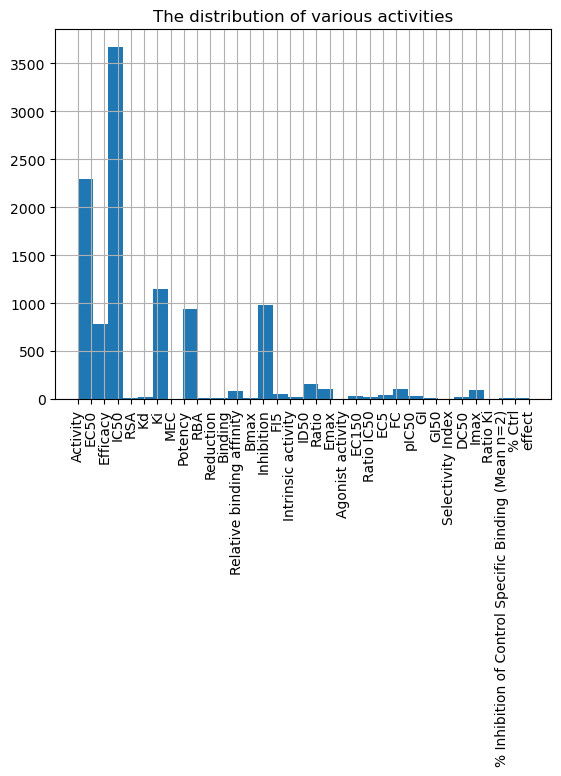

In [14]:
_ = data["act_standard_type"].hist(bins=30)
plt.title("The distribution of various activities")
plt.xticks(rotation=90)
#plt.savefig(fname="activities_distribution.pdf", format="pdf", dpi=200, bbox_inches="tight")#, pad_inches=2)

* remove tha rows for which the "standard_value" and "standard_units" is nan

In [15]:
data[pd.isna(data["act_standard_type"])].shape

(0, 139)

In [16]:
data[pd.isna(data["act_standard_type"])].shape

(0, 139)

In [17]:
data = data[~pd.isna(data["act_standard_value"])]
data = data[~pd.isna(data["act_standard_units"])]
data.shape

(8479, 139)

In [18]:
data[data["act_standard_type"]=="IC50"].groupby("mold_molregno").count()["act_standard_value"].value_counts()

1     1692
2      449
3       99
4       44
5       29
6        9
28       2
7        2
8        1
10       1
18       1
17       1
55       1
Name: act_standard_value, dtype: int64

In [19]:
data[data["act_standard_type"]=="IC50"].groupby("mold_molregno").count()

,act_activity_id,act_assay_id,act_doc_id,act_record_id,act_molregno,act_standard_relation,act_standard_value,act_standard_units,act_standard_flag,act_standard_type,act_activity_comment,act_data_validity_comment,act_potential_duplicate,act_pchembl_value,act_bao_endpoint,act_uo_units,act_qudt_units,act_toid,act_upper_value,act_standard_upper_value,act_src_id,act_type,act_relation,act_value,act_units,act_text_value,act_standard_text_value,act_action_type,ass_assay_id,ass_doc_id,ass_description,ass_assay_type,ass_assay_test_type,ass_assay_category,ass_assay_organism,ass_assay_tax_id,ass_assay_strain,ass_assay_tissue,ass_assay_cell_type,ass_assay_subcellular_fraction,ass_tid,ass_relationship_type,ass_confidence_score,ass_curated_by,ass_src_id,ass_src_assay_id,ass_chembl_id,ass_cell_id,ass_bao_format,ass_tissue_id,ass_variant_id,ass_aidx,doc_doc_id,doc_journal,doc_year,doc_volume,doc_issue,doc_first_page,doc_last_page,doc_pubmed_id,doc_doi,doc_chembl_id,doc_title,doc_doc_type,doc_authors,doc_abstract,doc_patent_id,doc_ridx,doc_src_id,doc_chembl_release_id,tar_tid,tar_target_type,tar_pref_name,tar_tax_id,tar_organism,tar_chembl_id,tar_species_group_flag,coms_molregno,coms_molfile,coms_standard_inchi,coms_standard_inchi_key,coms_canonical_smiles,comp_molregno,comp_mw_freebase,comp_alogp,comp_hba,comp_hbd,comp_psa,comp_rtb,comp_ro3_pass,comp_num_ro5_violations,comp_cx_most_apka,comp_cx_most_bpka,comp_cx_logp,comp_cx_logd,comp_molecular_species,comp_full_mwt,comp_aromatic_rings,comp_heavy_atoms,comp_qed_weighted,comp_mw_monoisotopic,comp_full_molformula,comp_hba_lipinski,comp_hbd_lipinski,comp_num_lipinski_ro5_violations,comp_np_likeness_score,mold_pref_name,mold_chembl_id,mold_max_phase,mold_therapeutic_flag,mold_dosed_ingredient,mold_structure_type,mold_chebi_par_id,mold_molecule_type,mold_first_approval,mold_oral,mold_parenteral,mold_topical,mold_black_box_warning,mold_first_in_class,mold_chirality,mold_prodrug,mold_inorganic_flag,mold_usan_year,mold_availability_type,mold_usan_stem,mold_polymer_flag,mold_usan_substem,mold_usan_stem_definition,mold_indication_class,mold_withdrawn_flag,mold_chemical_probe,mold_natural_product,lig_activity_id,lig_bei,lig_sei,lig_le,lig_lle
mold_molregno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
716,2,2,2,2,2,2,2,2,2,2,0,0,2,1,2,2,2,0,0,0,2,2,2,2,2,0,0,0,2,2,2,2,0,0,0,0,0,0,2,0,2,2,2,2,2,0,2,1,2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,2,2,2,0,2,0,2,2,2,2,2,2,2,2,0,2,0,2,0,0,0,2,2,2,1,1,1,1,1
717,55,55,55,55,55,55,55,55,55,55,1,1,55,52,55,55,55,0,0,0,55,55,55,55,54,0,0,4,55,55,55,55,14,0,48,47,0,0,49,0,55,55,55,55,55,20,55,40,55,0,9,55,55,54,55,54,54,54,54,54,54,55,55,55,54,54,1,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,0,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,0,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,26,26,26,26,26
790,2,2,2,2,2,2,2,2,2,2,0,0,2,1,2,2,2,0,0,0,2,2,2,2,2,0,0,0,2,2,2,2,0,0,0,0,0,0,2,0,2,2,2,2,2,0,2,1,2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,2,2,2,0,2,0,2,2,2,2,2,2,2,2,0,2,0,2,0,0,0,2,2,2,1,1,1,1,1
791,2,2,2,2,2,2,2,2,2,2,0,0,2,1,2,2,2,0,0,0,2,2,2,2,2,0,0,0,2,2,2,2,0,0,0,0,0,0,2,0,2,2,2,2,2,0,2,1,2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,2,2,2,0,2,0,2,2,2,2,2,2,2,2,0,2,0,2,0,0,0,2,2,2,1,1,1,1,1
799,2,2,2,2,2,2,2,2,2,2,0,0,2,1,2,2,2,0,0,0,2,2,2,2,2,0,0,0,2,2,2,2,0,0,0,0,0,0,2,0,2,2,2,2,2,0,2,1,2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,2,2,2,0,2,0,2,2,2,2,2,2,2,2,0,2,0,2,0,0,0,2,2,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [20]:
data.iloc[[-1], :]

,act_activity_id,act_assay_id,act_doc_id,act_record_id,act_molregno,act_standard_relation,act_standard_value,act_standard_units,act_standard_flag,act_standard_type,act_activity_comment,act_data_validity_comment,act_potential_duplicate,act_pchembl_value,act_bao_endpoint,act_uo_units,act_qudt_units,act_toid,act_upper_value,act_standard_upper_value,act_src_id,act_type,act_relation,act_value,act_units,act_text_value,act_standard_text_value,act_action_type,ass_assay_id,ass_doc_id,ass_description,ass_assay_type,ass_assay_test_type,ass_assay_category,ass_assay_organism,ass_assay_tax_id,ass_assay_strain,ass_assay_tissue,ass_assay_cell_type,ass_assay_subcellular_fraction,ass_tid,ass_relationship_type,ass_confidence_score,ass_curated_by,ass_src_id,ass_src_assay_id,ass_chembl_id,ass_cell_id,ass_bao_format,ass_tissue_id,ass_variant_id,ass_aidx,doc_doc_id,doc_journal,doc_year,doc_volume,doc_issue,doc_first_page,doc_last_page,doc_pubmed_id,doc_doi,doc_chembl_id,doc_title,doc_doc_type,doc_authors,doc_abstract,doc_patent_id,doc_ridx,doc_src_id,doc_chembl_release_id,tar_tid,tar_target_type,tar_pref_name,tar_tax_id,tar_organism,tar_chembl_id,tar_species_group_flag,coms_molregno,coms_molfile,coms_standard_inchi,coms_standard_inchi_key,coms_canonical_smiles,comp_molregno,comp_mw_freebase,comp_alogp,comp_hba,comp_hbd,comp_psa,comp_rtb,comp_ro3_pass,comp_num_ro5_violations,comp_cx_most_apka,comp_cx_most_bpka,comp_cx_logp,comp_cx_logd,comp_molecular_species,comp_full_mwt,comp_aromatic_rings,comp_heavy_atoms,comp_qed_weighted,comp_mw_monoisotopic,comp_full_molformula,comp_hba_lipinski,comp_hbd_lipinski,comp_num_lipinski_ro5_violations,comp_np_likeness_score,mold_molregno,mold_pref_name,mold_chembl_id,mold_max_phase,mold_therapeutic_flag,mold_dosed_ingredient,mold_structure_type,mold_chebi_par_id,mold_molecule_type,mold_first_approval,mold_oral,mold_parenteral,mold_topical,mold_black_box_warning,mold_first_in_class,mold_chirality,mold_prodrug,mold_inorganic_flag,mold_usan_year,mold_availability_type,mold_usan_stem,mold_polymer_flag,mold_usan_substem,mold_usan_stem_definition,mold_indication_class,mold_withdrawn_flag,mold_chemical_probe,mold_natural_product,lig_activity_id,lig_bei,lig_sei,lig_le,lig_lle
10647,24824357,2227497,123921,3877007,1515635,>,60.0,%,0,Activity,None,None,0,None,BAO_0001103,UO_0000187,http://qudt.org/vocab/unit#Percent,None,None,None,1,Activity,>,60.0,%,None,None,ANTAGONIST,2227497,123921,Antagonist activity at Androgen receptor in enzalutamide-resistant human LNCaP cells assessed as inhibition of PSA expression at 6 uM relative to control,B,None,None,Homo sapiens,9606.0,None,None,LNCaP,None,56,D,9,Autocuration,1,None,CHEMBL5141010,NaN,BAO_0000219,None,NaN,1413754,123921,J Med Chem,2022.0,65,13.0,8772,8797,35786895.0,10.1021/acs.jmedchem.2c00716,CHEMBL5137058,Therapeutic Strategies to Target the Androgen Receptor.,PUBLICATION,"Xiang W, Wang S.","The androgen receptor (AR) plays a key role in the maintenance of muscle and bone and the support of male sexual-related functions, as well as in the progression of prostate cancer. Accordingly, AR-targeted therapies have been developed for the treatment of related human diseases and conditions. AR agonists are an important class of drugs in the treatment of bone loss and muscle atrophy. AR antagonists have also been developed for the treatment of prostate cancer, including metastatic castra...",None,35786895,1,33,56,SINGLE PROTEIN,Androgen Receptor,9606,Homo sapiens,CHEMBL1871,0,1515635,\n RDKit 2D\n\n 23 25 0 0 0 0 0 0 0 0999 V2000\n 13.7230 -26.8848 0.0000 O 0 0 0 0 0 0 0 0 0 0 0 0\n 12.9058 -26.8848 0.0000 S 0 0 0 0 0 0 0 0 0 0 0 0\n 13.3144 -27.5925 0.0000 O 0 0 0 0 0 0 0 0 0 0 0 0\n 12.2028 -24.8418 0.0000 C 0 0 0 0 0 0 0 0 0 0 0 0\n 12.2017 -25.6613 0.0000 C 0 0 0 0 0 0 0 0 0 0 0 0\n 12.9097 -26.0703 0.0000 C 0 0 0 0 0 0 0 0 0 0 0 0\n ...,"InChI=1S/C16H16N2O3S2/c17-23(19,20)14-8-4-5-12-11-15(18-16(12)14)22-10-9-21-13-6-2-1-3-7-13/h1-8,11,18H,9-10H2,(H2,17,19,20)",ANFHSVOTUGCGOQ-UHF

In [21]:
aggFunctions = {
    "act_standard_value": get_all_levels,
    "act_standard_units": get_levels,
    "act_standard_type": get_levels,
    "act_activity_comment": get_levels,
    "act_bao_endpoint": get_concatenation_levels,
    "act_type": get_levels,
    "ass_assay_id": get_concatenation_levels,
    "ass_description": get_concatenation_levels,
    "ass_assay_type": get_concatenation_levels,
    "ass_assay_category": get_concatenation_levels,
    "ass_chembl_id": get_concatenation_levels,
    "doc_doi": get_concatenation_levels,
    "doc_pubmed_id": get_concatenation_levels,
    "doc_chembl_id": get_concatenation_levels,
    "doc_title": get_concatenation_levels,
    "doc_doc_type": get_concatenation_levels,
    "doc_abstract": get_concatenation_levels,
    "doc_patent_id": get_concatenation_levels,
    "coms_canonical_smiles": get_levels,
    "comp_full_molformula": get_levels,
    "mold_chembl_id": get_levels
}

def expand_activity(x, max_level_activity):
    expanded = [None for iii in range(max_level_activity)]
    n_act = len(x)
    expanded[:n_act] = x[:n_act]
    return np.array(expanded)

In [22]:
raw_types = data["act_standard_type"].unique().tolist()
clean_types = [item.replace(" ", "").replace("/", "").replace("%", "") for item in raw_types]

In [23]:
data["coms_canonical_smiles"]

4                                                 C[C@H]1Nc2cc3c(cc2C1(C)C)c(C(F)(F)F)cc(=O)n3C
5                                                  C[C@@H]1c2cc3c(C(F)(F)F)cc(O)nc3cc2N[C@@H]1C
6                                                        C[C@@H]1Cc2cc3c(C(F)(F)F)cc(O)nc3cc2N1
7                                         CCCN1c2cc3c(cc2[C@H]2CCCC[C@H]21)c(C(F)(F)F)cc(=O)n3C
8                                                              Oc1cc(C(F)(F)F)c2cc3c(cc2n1)NCC3
                                                  ...                                          
10643                                      COc1ccc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(OC)c(OC)c2)cc1OC
10644                                      COc1ccc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(OC)c(OC)c2)cc1OC
10645     CC1(C)C(=O)N(c2ccc(C#N)c(C(F)(F)F)c2)C(=S)N1CCCC(=O)NCCOCCOC(=O)CC12CC3CC(CC(C3)C1)C2
10646    CN1C(=O)C(F)=C[C@]2(C)[C@H]3CC[C@]4(C)[C@@H](O)/C(=C/c5cncnc5)C[C@H]4[C@@H]3CC[C@@H]12
10647                                   

In [24]:
data.shape

(8479, 139)

In [25]:
all_results = {} 
for chosen_type, clean_type in zip(raw_types, clean_types):
    data_slice = copy.deepcopy(data[data["act_standard_type"]==chosen_type])

    data_grouped = data_slice.groupby("comp_molregno")
    data_aggregated = data_grouped.agg(aggFunctions)
    max_level_activity = max(data_aggregated["act_standard_value"].apply(lambda x: len(x)))
    
    # data_aggregated.columns = [str(item[0])+"_"+str(item[1]) for item in data_aggregated.columns.to_flat_index().to_list()]

    all_activities = data_aggregated["act_standard_value"].apply(expand_activity, args=(max_level_activity,))
    data_aggregated = data_aggregated.drop(["act_standard_value"], axis=1)
    all_activities = pd.DataFrame(all_activities.to_list(), columns=["act_"+str(iii) for iii in range(max_level_activity)])
    all_activities = all_activities.set_index(data_aggregated.index)

    data_aggregated = pd.concat([data_aggregated, all_activities], axis=1)
    data_aggregated.to_csv("ar_homo_sapiens_chembl_3.3_more_ChEMBL_columns"+clean_type+".csv", index=True)
    all_results[clean_type] = data_aggregated
    print(data_aggregated.shape)

(664, 46)
(441, 42)
(2331, 75)
(351, 29)
(14, 30)
(925, 37)
(1, 21)
(624, 25)
(5, 22)
(6, 21)
(1, 29)
(372, 28)
(46, 22)
(17, 21)
(1, 21)
(38, 21)
(85, 23)
(2, 21)
(26, 21)
(29, 23)
(7, 22)
(23, 21)
(35, 26)
(8, 21)
(6, 21)
(1, 21)


In [26]:
data_aggregated

,act_standard_units,act_standard_type,act_activity_comment,act_bao_endpoint,act_type,ass_assay_id,ass_description,ass_assay_type,ass_assay_category,ass_chembl_id,doc_doi,doc_pubmed_id,doc_chembl_id,doc_title,doc_doc_type,doc_abstract,doc_patent_id,coms_canonical_smiles,comp_full_molformula,mold_chembl_id,act_0
comp_molregno,,,,,,,,,,,,,,,,,,,,,
1441223,%,effect,NaN,BAO_0000179,effect,2142929,hAR Cerep panel,B,NaN,CHEMBL4886482,10.6019/CHEMBL4800727,NaN,CHEMBL4800727,Data for DCP probe JNJ-42396302,DATASET,SGC Frankfurt donated chemical probe project: JNJ-42396302 was donated by Janssen. Website: https://www.sgc-ffm.uni-frankfurt.de/#!specificprobeoverview/JNJ-42396302. Control: JNJ-40573663. References: not published,NaN,COCCc1ccc(-c2c(C)nc3c(N4CCOCC4)ccnn23)cn1,C19H23N5O2,CHEMBL2180408,-13.85


In [30]:
pd.read_csv("ar_homo_sapiens_chembl_3.3_more_ChEMBL_columnsIC50.csv")#["coms_canonical_smiles"]

,comp_molregno,act_standard_units,act_standard_type,act_activity_comment,act_bao_endpoint,act_type,ass_assay_id,ass_description,ass_assay_type,ass_assay_category,ass_chembl_id,doc_doi,doc_pubmed_id,doc_chembl_id,doc_title,doc_doc_type,doc_abstract,doc_patent_id,coms_canonical_smiles,comp_full_molformula,mold_chembl_id,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12,act_13,act_14,act_15,act_16,act_17,act_18,act_19,act_20,act_21,act_22,act_23,act_24,act_25,act_26,act_27,act_28,act_29,act_30,act_31,act_32,act_33,act_34,act_35,act_36,act_37,act_38,act_39,act_40,act_41,act_42,act_43,act_44,act_45,act_46,act_47,act_48,act_49,act_50,act_51,act_52,act_53,act_54
0,716,nM,IC50,NaN,"Entry 0: BAO_0000190, Entry 1: BAO_0000190,",IC50,"Entry 0: 36116, Entry 1: 36117,","Entry 0: In vitro antagonistic activity against human androgen receptor using cotransfection assay in CV-1 cells; Not active., Entry 1: In vitro binding affinity at human androgen receptor transfected into COS cells.,","Entry 0: F, Entry 1: B,",NaN,"Entry 0: CHEMBL648081, Entry 1: CHEMBL648082,","Entry 0: 10.1016/s0960-894x(99)00118-3, Entry 1: 10.1016/s0960-894x(99)00118-3,","Entry 0: 10230628, Entry 1: 10230628,","Entry 0: CHEMBL1132082, Entry 1: CHEMBL1132082,","Entry 0: Nonsteroidal androgen receptor agonists based on 4-(trifluoromethyl)-2H-pyrano[3,2-g]quinolin-2-one., Entry 1: Nonsteroidal androgen receptor agonists based on 4-(trifluoromethyl)-2H-pyrano[3,2-g]quinolin-2-one.,","Entry 0: PUBLICATION, Entry 1: PUBLICATION,","Entry 0: A series of 2H-pyrano[3,2-g]quinolin-2-ones was prepared and tested for the ability to modulate the transcriptional activity of the human androgen receptor (hAR). The parent compound, 4-(trifluoromethyl)-2H-pyrano[3,2-g]quinolin-2-one, displayed moderate interaction with hAR, but substituted analogues were potent hAR modulators in vitro as measured by an hAR cotransfection assay in CV-1 cells and bound to hAR with high affinity in a whole cell assay. Several analogues were able to a...",NaN,CCC1CCNc2cc3oc(=O)cc(C(F)(F)F)c3cc21,C15H14F3NO2,CHEMBL6843,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,717,nM,IC50,325861,"Entry 0: BAO_0000190, Entry 1: BAO_0000190, Entry 2: BAO_0000190, Entry 3: BAO_0000190, Entry 4: BAO_0000190, Entry 5: BAO_0000190, Entry 6: BAO_0000190, Entry 7: BAO_0000190, Entry 8: BAO_0000190, Entry 9: BAO_0000190, Entry 10: BAO_0000190, Entry 11: BAO_0000190, Entry 12: BAO_0000190, Entry 13: BAO_0000190, Entry 14: BAO_0000190, Entry 15: BAO_0000190, Entry 16: BAO_0000190, Entry 17: BAO_0000190, Entry 18: BAO_0000190, Entry 19: BAO_0000190, Entry 20: BAO_0000190, Entry 21: BAO_0000190, ...",mix,"Entry 0: 36100, Entry 1: 36107, Entry 2: 36115, Entry 3: 36117, Entry 4: 36124, Entry 5: 305503, Entry 6: 312479, Entry 7: 312709, Entry 8: 312710, Entry 9: 312787, Entry 10: 312999, Entry 11: 317578, Entry 12: 327103, Entry 13: 312372, Entry 14: 432232, Entry 15: 432234, Entry 16: 438255, Entry 17: 449391, Entry 18: 449393, Entry 19: 464721, Entry 20: 467616, Entry 21: 467618, Entry 22: 479688, Entry 23: 629229, Entry 24: 643541, Entry 25: 643543, Entry 26: 629235, Entry 27: 663713, Entry 2...","Entry 0: Antagonistic activity (IC50) against human androgen receptor (hAR) in co-transfected CV-1 cell, Entry 1: Antagonistic activity against human androgen receptor (hAR) in co-transfected CV-1 cells., Entry 2: In vitro agonistic activity against human androgen receptor (hAR) expressed in CV-1 cells; not active, Entry 3: In vitro binding affinity at human androgen receptor transfected into COS cells., Entry 4: Inhibitory concentration against human androgen receptor (AR) dependent transcr...","Entry 0: F, Entry 1: F, Entry 2: F, Entry 3: B, Entry 4: F, Entry 5: B, Entry 6: F, Entry 7: F, Entry 8: F, Entry 9: F, Entry 10: F, Entry 11: 

In [27]:
data_aggregated["coms_canonical_smiles"]

comp_molregno
1441223    COCCc1ccc(-c2c(C)nc3c(N4CCOCC4)ccnn23)cn1
Name: coms_canonical_smiles, dtype: object

In [68]:
all_results["IC50"]``

,act_standard_units,act_standard_type,act_activity_comment,act_bao_endpoint,act_type,ass_assay_id,ass_description,ass_assay_type,ass_assay_category,ass_chembl_id,doc_doi,doc_pubmed_id,doc_chembl_id,doc_title,doc_doc_type,doc_abstract,doc_patent_id,coms_canonical_smiles,comp_full_molformula,mold_chembl_id,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12,act_13,act_14
comp_molregno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2208,nM,IC50,NaN,BAO_0000190,pIC50,1434915,Inverse agonist activity at RORgammaT (unknown origin) by M1H assay,B,NaN,CHEMBL3385309,10.1016/j.bmcl.2014.09.053,25305688,CHEMBL3352412,Identification of the first inverse agonist of retinoid-related orphan receptor (ROR) with dual selectivity for RORβ and RORγt.,PUBLICATION,Retinoic acid receptor-related orphan nuclear receptor gamma t (RORγt) is a key transcription factor for the development of Th17 cells. Inhibiting RORγt activity is thought to be beneficial in targeting a variety of inflammatory and autoimmune disorders. Recently N-(5-(arylcarbonyl)thiazol-2-yl)amides were described as RORγt antagonists with in vivo efficacy in experimental autoimmune encephalomyelitis (EAE) and collagen-induced arthritis (CIA) via oral administration. So far no selective sm...,NaN,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,C20H28O2,CHEMBL38,199.53,None,None,None,None,None,None,None,None,None,None,None,None,None,None
40459,nM,IC50,inactive,BAO_0000190,IC50_Mean,845260,PubChem BioAssay. Dose response orthogonal assay of uHTS small molecule inhibitors of Striatal-Enriched Phosphatase via a colorimetric intensity assay. (Class of assay: confirmatory),F,confirmatory,CHEMBL2114928,NaN,NaN,CHEMBL1201862,PubChem BioAssay data set,DATASET,NaN,NaN,O=C(O)C(S)C(S)C(=O)O,C4H6O4S2,CHEMBL28721,31900.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None
92776,nM,IC50,Active,"Entry 0: BAO_0000190, Entry 1: BAO_0000190, Entry 2: BAO_0000190, Entry 3: BAO_0000190, Entry 4: BAO_0000190, Entry 5: BAO_0000190, Entry 6: BAO_0000190, Entry 7: BAO_0000190, Entry 8: BAO_0000190, Entry 9: BAO_0000190, Entry 10: BAO_0000190, Entry 11: BAO_0000190, Entry 12: BAO_0000190, Entry 13: BAO_0000190, Entry 14: BAO_0000190,",mix,"Entry 0: 737070, Entry 1: 1279577, Entry 2: 1331803, Entry 3: 1338694, Entry 4: 1338695, Entry 5: 1338698, Entry 6: 1351232, Entry 7: 1434910, Entry 8: 1434915, Entry 9: 1457046, Entry 10: 1457056, Entry 11: 1563237, Entry 12: 1571959, Entry 13: 1778222, Entry 14: 1892509,","Entry 0: PUBCHEM_BIOASSAY: Late stage results from the probe development effort to identify novel modulators of the Retinoic acid receptor-related Orphan Receptors (ROR). (Class of assay: screening) [Related pubchem assays (depositor defined):AID2139, AID2277] Panel member name: RORG, Entry 1: Displacement of [3H2]-25-hydroxycholesterol from N-terminal 6xHis-tagged human RORc ligand binding domain (241 to 486) expressed in bacterial expression system after 3 hrs by scintillation counting ana...","Entry 0: U, Entry 1: B, Entry 2: B, Entry 3: B, Entry 4: B, Entry 5: B, Entry 6: B, Entry 7: B, Entry 8: B, Entry 9: B, Entry 10: B, Entry 11: B, Entry 12: B, Entry 13: B, Entry 14: B,",screening,"Entry 0: CHEMBL1738628, Entry 1: CHEMBL3097490, Entry 2: CHEMBL3227246, Entry 3: CHEMBL3242032, Entry 4: CHEMBL3242033, Entry 5: CHEMBL3242036, Entry 6: CHEMBL3271687, Entry 7: CHEMBL3385304, Entry 8: CHEMBL3385309, Entry 9: CHEMBL3368931, Entry 10: CHEMBL3369177, Entry 11: CHEMBL3784297, Entry 12: CHEMBL3796417, Entry 13: CHEMBL4235214, Entry 14: CHEMBL4394430,","Entry 0: 10.1016/j.bmcl.2013.10.054, Entry 1: 10.1039/C3MD00005B, Entry 2: 10.1016/j.ejmech.2014.03.065, Entry 3: 10.1016/j.ejmech.2014.03.065, Entry 4: 10.1016/j.ejmech.2014.03.065, Entry 5: 10.1016/j.bmc.2014.03.007, Entry 6: 10.1016/j.bmcl.2014.09.053, Entry 7: 10.1016/j.bmcl.2014.09.053, Entry 8: 10.1021/jm401901d, Entry 9: 10.1021/jm401901d, Entry 10: 10.1016/j.bmcl.2016.02.031, Entry 11: 10.1016/j.bmcl.2016.03.109, Entr